In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import cudaq
from cudaq import spin

# Importing standard Qiskit libraries 
from qiskit import *
from qiskit_aer import *
# from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
# from qiskit.tools.jupyter import *
from qiskit.visualization import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
from PIL import Image
from numpy import asarray
import torch
from torchvision import datasets, transforms
from PIL import Image
from qiskit_machine_learning.circuit.library import RawFeatureVector
from qiskit.circuit.library import RealAmplitudes
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42


In [2]:
def img_to_qhed(image):
    new_image = image.resize((16, 16)).convert('1')
    imgg = np.asarray(new_image)

    def amplitude_encode(img_data):
    
        # Calculate the RMS value
        rms_16 = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
        
        # Create normalized image
        image_norm = []
        for arr in img_data:
            for ele in arr:
                image_norm.append(ele / rms_16)
            
        # Return the normalized image as a numpy array
        return np.array(image_norm)


    h_norm_image_16 = amplitude_encode(imgg)
    v_norm_image_16 = amplitude_encode(imgg.T)

    data_q_16 = 8
    ancillary_q_16 = 1
    total_q_16 = data_q_16 + ancillary_q_16
    
    # Initialize the amplitude permutation unitary
    Amp_permutation_unitary_16 = np.identity(2**total_q_16)
    Amp_permutation_unitary_16=np.roll(Amp_permutation_unitary_16,1,axis=1)

    # Creating the circuit for horizontal scan
    
    qc_h_16 = QuantumCircuit(total_q_16)
    qc_h_16.initialize(h_norm_image_16, range(1, total_q_16))
    qc_h_16.h(0)
    qc_h_16.unitary(Amp_permutation_unitary_16, range(total_q_16))
    qc_h_16.h(0)    
    
    # Create the circuit for vertical scan
    qc_v_16 = QuantumCircuit(total_q_16)
    qc_v_16.initialize(v_norm_image_16, range(1, total_q_16))
    qc_v_16.h(0)
    qc_v_16.unitary(Amp_permutation_unitary_16, range(total_q_16))
    qc_v_16.h(0)
        
    # Combine both circuits into a single list
    circ_list_16 = [qc_h_16, qc_v_16]

    # Simulating cirucits
    back = Aer.get_backend('statevector_simulator')
    results = back.run(circ_list_16).result()
    state_vector_h_16 = results.get_statevector(qc_h_16)
    state_vector_v_16 = results.get_statevector(qc_v_16)

    #  Post processing for plotting the output (Classical)

    # Defining a lambda function for thresholding to binary values
    # returns true for specified Amplitude values else false
    threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)
    
    # Selecting odd states from the raw statevector and
    # reshaping column vector of size 64 to an 8x8 matrix
    h_edge_scan_img_16 = np.abs(np.array([1 if threshold(state_vector_h_16[2*(i)+1].real) else 0 for i in range(2**data_q_16)])).reshape(16, 16)
    v_edge_scan_img_16= np.abs(np.array([1 if threshold(state_vector_v_16[2*(i)+1].real) else 0 for i in range(2**data_q_16)])).reshape(16, 16).T

    edge_scan_image_16 = h_edge_scan_img_16 | v_edge_scan_img_16

    return edge_scan_image_16

In [3]:
def img_preprocess(image):
    binary_array = img_to_qhed(image)
    binary_image = Image.fromarray((binary_array * 255).astype(np.uint8), mode='L')
    return binary_image

In [4]:
sample_count = 150
X_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
)
# Leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:sample_count],
    np.where(X_train.targets == 1)[0][:sample_count],
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor()
])

X_train = [(transform(img), label) for (img, label) in X_train]
train_loader = DataLoader(X_train, batch_size=1, shuffle=True)

In [5]:
n_samples = 50

X_test = datasets.MNIST(
    root="./data", train=False, download=True
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor()
])

X_test = [(transform(img), label) for (img, label) in X_test]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=1, shuffle=True)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
sample_count = 150

X_train = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)

# Leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:sample_count],
    np.where(X_train.targets == 1)[0][:sample_count],
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

# Test set
sample_count = 50

X_test = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()]),
)
idx = np.append(
    np.where(X_test.targets == 0)[0][:sample_count],
    np.where(X_test.targets == 1)[0][:sample_count],
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]
test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [7]:
class QuantumCircuit:
    """This class defines the quantum circuit structure and the run method which is used to calculate an expectation value"""

    def __init__(self, qubit_count: int):
        """Define the quantum circuit in CUDA Quantum"""

        kernel, thetas = cudaq.make_kernel(list)

        self.kernel = kernel

        self.theta = thetas

        qubits = kernel.qalloc(qubit_count)

        self.kernel.h(qubits)

        # Variational gate parameters which are optimised during training
        for i in range(qubit_count):
            kernel.rx(thetas[16*i], qubits[i])
            if i != qubit_count-1:
                kernel.crx(thetas[16*i+1],qubits[i],qubits[i+1])
            else:
                kernel.crx(thetas[16*i+1],qubits[i],qubits[0])
            kernel.ry(thetas[16*i+2], qubits[i])
            if i != qubit_count-1:
                kernel.cry(thetas[16*i+3],qubits[i],qubits[i+1])
            else:
                kernel.cry(thetas[16*i+3],qubits[i],qubits[0])
            kernel.rz(thetas[16*i+4], qubits[i])
            if i != qubit_count-1:
                kernel.crz(thetas[16*i+5],qubits[i],qubits[i+1])
            else:
                kernel.crz(thetas[16*i+5],qubits[i],qubits[0])
            kernel.rx(thetas[16*i+6], qubits[i])
            if i != qubit_count-1:
                kernel.crx(thetas[16*i+7],qubits[i],qubits[i+1])
            else:
                kernel.crx(thetas[16*i+7],qubits[i],qubits[0])
            kernel.ry(thetas[16*i+8], qubits[i])
            if i != qubit_count-1:
                kernel.cry(thetas[16*i+9],qubits[i],qubits[i+1])
            else:
                kernel.cry(thetas[16*i+9],qubits[i],qubits[0])
            kernel.rz(thetas[16*i+10], qubits[i])
            if i != qubit_count-1:
                kernel.crz(thetas[16*i+11],qubits[i],qubits[i+1])
            else:
                kernel.crz(thetas[16*i+11],qubits[i],qubits[0])
            kernel.rx(thetas[16*i+12], qubits[i])
            if i != qubit_count-1:
                kernel.crx(thetas[16*i+13],qubits[i],qubits[i+1])
            else:
                kernel.crx(thetas[16*i+13],qubits[i],qubits[0])
            kernel.ry(thetas[16*i+14], qubits[i])
            if i != qubit_count-1:
                kernel.cry(thetas[16*i+15],qubits[i],qubits[i+1])
            else:
                kernel.cry(thetas[16*i+15],qubits[i],qubits[0])

        hamiltonian = spin.z(0)
        for i in range(1, qubit_count):
            hamiltonian *= spin.z(i)
        self.hamiltonian = hamiltonian

    def run(self, thetas: torch.tensor) -> torch.tensor:
        """Excetute the quantum circuit to output an expectation value"""
        expectation = torch.tensor(cudaq.observe(self.kernel, self.hamiltonian,
                                                 thetas).expectation(),
                                   device=device)

        return expectation
class QuantumFunction(Function):
    """Allows the quantum circuit to pass data through it and compute the gradients"""

    @staticmethod
    def forward(ctx, thetas: torch.tensor, quantum_circuit,
                shift) -> torch.tensor:
        # Save shift and quantum_circuit in context to use in backward
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        # Calculate exp_val
        expectation_z = ctx.quantum_circuit.run(thetas)

        ctx.save_for_backward(thetas, expectation_z)
        return expectation_z

    @staticmethod
    def backward(ctx, grad_output):
        """Backward pass computation via finite difference parameter shift"""

        thetas, expectation_z = ctx.saved_tensors

        gradients = torch.zeros(len(thetas), device=device)

        for i in range(len(thetas)):
            shift_right = torch.clone(thetas)

            shift_right[i] += ctx.shift

            shift_left = torch.clone(thetas)

            shift_left[i] -= ctx.shift

            expectation_right = ctx.quantum_circuit.run(shift_right)
            expectation_left = ctx.quantum_circuit.run(shift_left)

            gradients[i] = 0.5 * (expectation_right - expectation_left)

        return gradients * grad_output.float(), None, None

In [8]:
class QuantumLayer(nn.Module):
    """Encapsulates a quantum circuit and a quantum function into a quantum layer"""

    def __init__(self, shift: torch.tensor):
        super(QuantumLayer, self).__init__()
        self.quantum_circuit = QuantumCircuit(8)
        self.shift = shift

    def forward(self, input):
        ans = QuantumFunction.apply(input, self.quantum_circuit, self.shift)
        return ans
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # Neural network structure
        self.fc0 = nn.Linear(256, 128)
        # self.fc1 = nn.Linear(256, 32)
        self.hybrid = QuantumLayer(
            torch.tensor(np.pi / 2)
        )  # Input is the magnitude of the parameter shifts to calculate gradients

    def forward(self, x):
        x = x.view(1, -1)
        x = F.relu(self.fc0(x)).reshape(-1)
        # x = F.relu(self.fc1(x)).reshape(-1)
        x = self.hybrid(x).reshape(-1)
        return torch.cat((x, 1 - x), -1).unsqueeze(0)

In [9]:
model = Net().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_func = nn.NLLLoss().to(device)

epochs = 10

epoch_loss = []

model.train()
for epoch in range(epochs):
    batch_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):  # batch training
        optimizer.zero_grad()

        data, target = data.to(device), target.to(device)

        # Forward pass
        output = model(data).to(device)

        # Calculating loss
        loss = loss_func(output, target).to(device)

        # Backward pass
        loss.backward()

        # Optimize the weights
        optimizer.step()

        batch_loss += loss.item()

    epoch_loss.append(batch_loss / batch_idx)

    print("Training [{:.0f}%]\tLoss: {:.4f}".format(
        100.0 * (epoch + 1) / epochs, epoch_loss[-1]))

Training [10%]	Loss: -1.0732
Training [20%]	Loss: -1.3259
Training [30%]	Loss: -1.3830
Training [40%]	Loss: -1.4061
Training [50%]	Loss: -1.4230
Training [60%]	Loss: -1.4288
Training [70%]	Loss: -1.4421
Training [80%]	Loss: -1.4451
Training [90%]	Loss: -1.4518
Training [100%]	Loss: -1.4578


Text(0, 0.5, 'Neg Log Likelihood Loss')

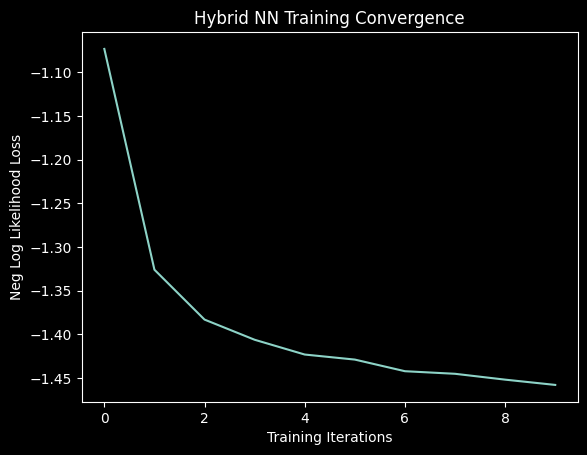

In [10]:
plt.plot(epoch_loss)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")

plt.ylabel("Neg Log Likelihood Loss")

In [11]:
model.eval()
with torch.no_grad():
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)

        output = model(data).to(device)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        epoch_loss.append(loss.item())

    print("Performance on test data:\n\tAccuracy: {:.1f}%".format(
        correct / len(test_loader) * 100))

Performance on test data:
	Accuracy: 100.0%
